In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)
mpl.rc('text', usetex=False)

#have to install my version of mdtraj, in code dir
sys.path.insert(0,"/home/glen842/software/mdtraj-2Dec2015/lib/python2.7/site-packages/mdtraj-1.6.0.dev1-py2.7-linux-x86_64.egg")

import mdtraj as md
import cgmap as cgmap
import data_tools as dt

In [2]:
def get_table_results(data,first_time_ns,time_column=0,t_column=2,d_column=1):
    sub_data = data[data[:,time_column]/1e3>first_time_ns]
    distances = sub_data[:,d_column]*10
    torsions = -np.degrees(sub_data[:,t_column])
    results = {'mean_t': torsions.mean(), 'mean_d': distances.mean(), 'mean_t2': (torsions*torsions).mean(), 'mean_d2': (distances*distances).mean(),
              # 'var_t': torsions.var(),  'var_d': distances.var(), 'sig_t':torsions.std(), 'sig_d':distances.std()
              }
    return results
    
#times in ns

target_t=-0.110262*(180./np.pi)
target_t2=0.0124479*((180./np.pi)**2)

target_d=2.06155*10
target_d2=4.25029*100


In [3]:
output_directory = "cgds-figures"
!mkdir -p {output_directory}

output_directory_aa_analysis = os.path.join(output_directory,"aa_analysis")
!mkdir -p {output_directory_aa_analysis}
output_directory_cg_eds = os.path.join(output_directory,"cg_eds")
!mkdir -p {output_directory_cg_eds}
output_directory_aa_eds = os.path.join(output_directory,"aa_eds")
!mkdir -p {output_directory_aa_eds}

In [4]:
#get aa data for fig 1
psf_file="Trajectories/Reference/oda-atp-13mer-frommono_ionized.notwater.psf"
xtcfiles = "Trajectories/Reference/oda-atp-13mer-frommono_ionized_npt_every50ps.stepid150000000.every100ps.nowater.xtc"

trj = md.load(xtcfiles,top=psf_file,stride=2)
for a in trj.top.atoms: a.mass = a.element.mass
for a in trj.top.atoms: a.charge = 0
trj.forces = 0*trj.xyz

psf_file_gatp = "Trajectories/Reference/actin-gatpu_ionized.notwater.psf"
trrfiles_gatp = "Trajectories/Reference/actin-atp-gu_ionized.stepid112500000.every125ps.nowater.xtc"

trj_gatp = md.load(trrfiles_gatp,top=psf_file_gatp,stride=2)
for a in trj_gatp.top.atoms: a.mass = a.element.mass
for a in trj_gatp.top.atoms: a.charge = 0
trj_gatp.forces = 0*trj_gatp.xyz

psf_file_fatp = "Trajectories/Reference/actin-atp-f_ionized.nowater.psf"
trrfiles_fatp = "Trajectories/Reference/actin-atp-f_ionized.stepid150000000.every125ps.nowater.xtc"
trj_fatp = md.load(trrfiles_fatp,top=psf_file_fatp,stride=2)
for a in trj_fatp.top.atoms: a.mass = a.element.mass
for a in trj_fatp.top.atoms: a.charge = 0
trj_fatp.forces = 0*trj_fatp.xyz

#coarse grain trajectories
selstring="(name CA or name CB)"
from actin_cg import mdtraj_twelvesite_template as mdtraj_twelvesite_template_cacb
sel_list,label_list, resSeq_list, segment_id_list, chain_list = mdtraj_twelvesite_template_cacb(13,actin_seg_template='A%i and '+selstring)
actin_13mer_12site_cacb = cgmap.cg_by_selection(trj,sel_list, bead_label_list=label_list, resSeq_list=resSeq_list, segment_id_list=segment_id_list )

sel_list,label_list, resSeq_list, segment_id_list, chain_list = mdtraj_twelvesite_template_cacb(1,actin_seg_template='A and '+selstring)
actin_gatp_12site_cacb = cgmap.cg_by_selection(trj_gatp,sel_list, bead_label_list=label_list, resSeq_list=resSeq_list, segment_id_list=segment_id_list )
actin_fatp_12site_cacb = cgmap.cg_by_selection(trj_fatp,sel_list, bead_label_list=label_list, resSeq_list=resSeq_list, segment_id_list=segment_id_list )

In [5]:
sel_list,label_list, resSeq_list, segment_id_list, chain_list = mdtraj_twelvesite_template_cacb(13,actin_seg_template='A%i and '+selstring)
rmsds = []
rmsds_self = []
for j in range(1,14):
    sel1 = "segname A%i"%j
    ids1 = trj.top.select(sel1)
    for i in range(1,14):
        sel2 = "segname A%i"%i
        ids2 = trj.top.select(sel2)
        rmsd = md.rmsd( trj[trj.time/1e3>200], trj[trj.time/1e3>200], atom_indices=ids1, ref_atom_indices=ids2 )
        rmsds.append(rmsd)
rmsds = np.array(rmsds)

3.34316 0.300404


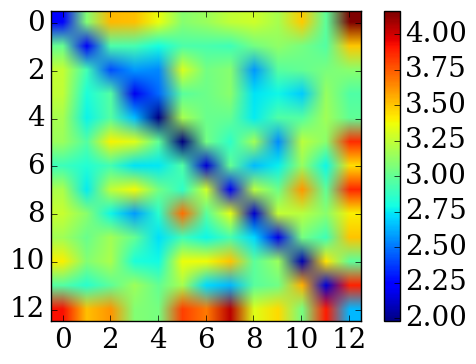

In [6]:
rmsd_matrix = rmsds.mean(axis=1).reshape(13,13)*10
plt.imshow(rmsd_matrix)
plt.colorbar()

print rmsd_matrix[0,1:].mean(), rmsd_matrix[0,1:].std()


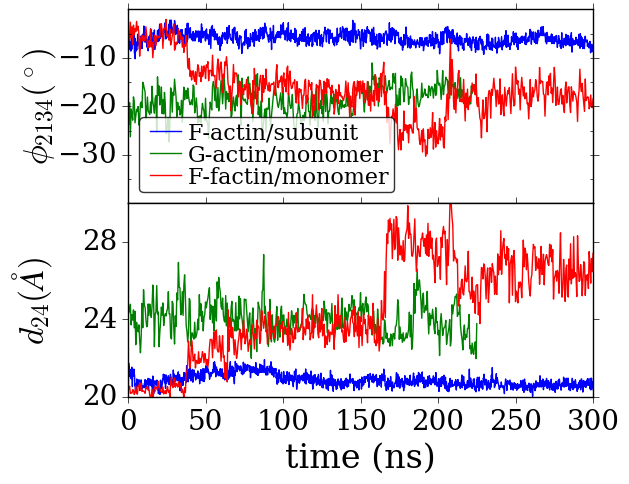

In [7]:
nmonomers=13
beads_per_monomer = 12

f = plt.figure(figsize=(6.,5.0))
ax1 = f.add_subplot(2, 1, 1)
ax2 = f.add_subplot(2, 1, 2,sharex=ax1)


plt.setp([ax1.get_xticklabels() for a in f.axes[:-1]], visible=False)
#next line is hack to set exact size
#plt.subplots_adjust(0,0,1,1,wspace=0, hspace=0)
plt.subplots_adjust(wspace=0, hspace=0)


dihedrals_list_filaments = [ (1+i*beads_per_monomer,0+i*beads_per_monomer,2+i*beads_per_monomer,3+i*beads_per_monomer) for i in range(nmonomers) ]
filament_dihedrals = ( md.compute_dihedrals(actin_13mer_12site_cacb, dihedrals_list_filaments,periodic=True) )
#plt.plot(actin_13mer_12site_cacb.time/1e3,np.degrees(filament_dihedrals[:,:].mean(axis=1)),label='fil_avg')
ax1.plot(actin_13mer_12site_cacb.time/1e3,np.degrees(filament_dihedrals[:,0]),label='F-actin/subunit')

gatp_dihedral = ( md.compute_dihedrals(actin_gatp_12site_cacb, (dihedrals_list_filaments[0],),periodic=True) )
ax1.plot(actin_gatp_12site_cacb.time/1e3,np.degrees(gatp_dihedral.mean(axis=1)),label='G-actin/monomer')

fatp_dihedral = ( md.compute_dihedrals(actin_fatp_12site_cacb, (dihedrals_list_filaments[0],),periodic=True) )
ax1.plot(actin_fatp_12site_cacb.time/1e3,np.degrees(fatp_dihedral.mean(axis=1)),label='F-factin/monomer')

ax1.legend(loc='lower left',fontsize=16,fancybox=True,framealpha=0.8,labelspacing=0,borderpad=0.2,handletextpad=0)


distance_list_filaments = [ (1+i*beads_per_monomer,3+i*beads_per_monomer) for i in range(nmonomers) ]
filament_distance = ( md.compute_distances(actin_13mer_12site_cacb, distance_list_filaments,periodic=True) )
ax2.plot(actin_13mer_12site_cacb.time/1e3,filament_distance[:,0]*10,label='fil_single')
gatp_distance = ( md.compute_distances(actin_gatp_12site_cacb, (distance_list_filaments[0],),periodic=True) )
ax2.plot(actin_gatp_12site_cacb.time/1e3,gatp_distance.mean(axis=1)*10,label='gatp')
fatp_distance = ( md.compute_distances(actin_fatp_12site_cacb, (distance_list_filaments[0],),periodic=True) )
ax2.plot(actin_fatp_12site_cacb.time/1e3,fatp_distance.mean(axis=1)*10,label='fatp')

filament_aa_data = np.concatenate( (actin_13mer_12site_cacb.time.reshape(-1,1), filament_distance[:,0].reshape(-1,1), -filament_dihedrals[:,0].reshape(-1,1)),  axis=-1 )
gatp_aa_data = np.concatenate( (actin_gatp_12site_cacb.time.reshape(-1,1), gatp_distance.reshape(-1,1), -gatp_dihedral.reshape(-1,1)),  axis=-1 )
fatp_aa_data = np.concatenate( (actin_fatp_12site_cacb.time.reshape(-1,1), fatp_distance.reshape(-1,1), -fatp_dihedral.reshape(-1,1)),  axis=-1 )


ax1.set_ylim(-40,0)
ax1.set_ylabel('$\phi_{2134} (^\circ)$',fontsize=24,labelpad=0)
ax1.set_yticks(np.arange(-30,0,10),minor=False)
ax1.set_yticks(np.arange(-40,0,5),minor=True)
ax1.get_yaxis().set_tick_params(direction='out')
ax1.get_xaxis().set_tick_params(direction='out')


ax2.set_ylabel('$d_{24} (\AA)$',fontsize=24,labelpad=20)
ax2.set_yticks(np.arange(20,30,4))
ax2.set_ylim(20,30)
ax2.get_yaxis().set_tick_params(direction='out')
ax2.get_xaxis().set_tick_params(direction='out')

plt.xlabel('time (ns)',fontsize=24)
plt.savefig(os.path.join(output_directory_aa_analysis,'atomistic-dihedral-distance.pdf'),bbox_inches='tight',transparent=True)



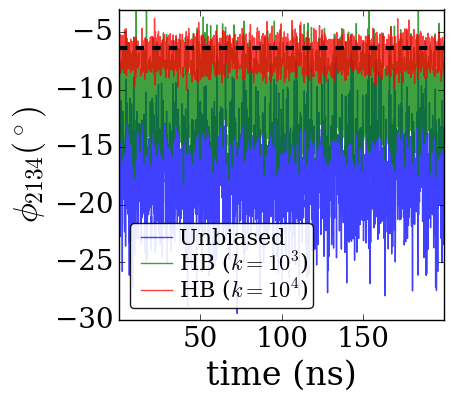

In [8]:
f = plt.figure(figsize=(4.2,4.0))
#plt.subplots_adjust(0,0,1,1)

noeds_gatp_ref = np.loadtxt("Trajectories/EDS-flattening-enm/no-eds/gatp-enm-12site_FEStart_eq175ns.no-eds/gatp-enm-12site_FEStart_eq175ns.no-eds.50ps.run.20000000.colvars.dat")
plt.plot(noeds_gatp_ref[::2,0]/1e3,-np.degrees(noeds_gatp_ref[::2,2]),label='Unbiased',alpha=0.75)
us_1000 = np.loadtxt('Trajectories/EDS-flattening-enm/us-flatten-dihed-mean/gatp-enm-12site_FEStart_eq175ns.flatten_us_k1000/gatp-enm-12site_FEStart_eq175ns.flatten_us_k1000.50ps.run.20000000.colvars.dat')
us_10000 = np.loadtxt('Trajectories/EDS-flattening-enm/us-flatten-dihed-mean/gatp-enm-12site_FEStart_eq175ns.flatten_us_k10000/gatp-enm-12site_FEStart_eq175ns.flatten_us_k10000.50ps.run.20000000.colvars.dat')
plt.plot(us_1000[::5,0]/1e3,-np.degrees(us_1000[::5,2]),label='HB ($k=10^3$)',alpha=0.75)
plt.plot(us_10000[::5,0]/1e3,-np.degrees(us_10000[::5,2]),label='HB ($k=10^4$)',alpha=0.75)
plt.axhline(target_t,color='black',linestyle='--',lw=3)
plt.legend(loc='lower left',fontsize=16,fancybox=True,framealpha=0.9,labelspacing=0,borderpad=0.2,handletextpad=0)


plt.xlim(0,200)
plt.ylabel('$\phi_{2134} (^\circ)$',fontsize=24)
plt.xlabel('time (ns)',fontsize=24)
plt.ylim(-30,-3)
plt.xticks(np.arange(50,175,50))

plt.savefig(os.path.join(output_directory_cg_eds,'umbrella-vs-unbiased.pdf'),bbox_inches='tight',transparent=True)

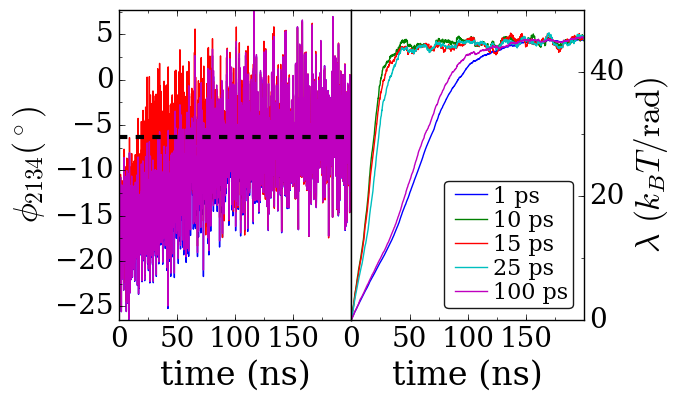

In [9]:
eds_mean_tau1 = np.loadtxt("Trajectories/EDS-flattening-enm/flatten-dihed-mean-target/meant_0.11/gatp-enm-12site_FEStart_eq175ns.range10_init0/gatp-enm-12site_FEStart_eq175ns.range10_init0.1ps.run.20000000.colvars.dat")
eds_mean_tau5 = np.loadtxt("Trajectories/EDS-flattening-enm/flatten-dihed-mean-target/meant_0.11/gatp-enm-12site_FEStart_eq175ns.range10_init0/gatp-enm-12site_FEStart_eq175ns.range10_init0.5ps.run.20000000.colvars.dat")
eds_mean_tau10 = np.loadtxt("Trajectories/EDS-flattening-enm/flatten-dihed-mean-target/meant_0.11/gatp-enm-12site_FEStart_eq175ns.range10_init0/gatp-enm-12site_FEStart_eq175ns.range10_init0.10ps.run.20000000.colvars.dat")
eds_mean_tau15 = np.loadtxt("Trajectories/EDS-flattening-enm/flatten-dihed-mean-target/meant_0.11/gatp-enm-12site_FEStart_eq175ns.range10_init0/gatp-enm-12site_FEStart_eq175ns.range10_init0.15ps.run.20000000.colvars.dat")
eds_mean_tau25 = np.loadtxt("Trajectories/EDS-flattening-enm/flatten-dihed-mean-target/meant_0.11/gatp-enm-12site_FEStart_eq175ns.range10_init0/gatp-enm-12site_FEStart_eq175ns.range10_init0.25ps.run.20000000.colvars.dat")
eds_mean_tau100 = np.loadtxt("Trajectories/EDS-flattening-enm/flatten-dihed-mean-target/meant_0.11/gatp-enm-12site_FEStart_eq175ns.range10_init0/gatp-enm-12site_FEStart_eq175ns.range10_init0.100ps.run.20000000.colvars.dat")

f = plt.figure(figsize=(6.0,4.0))
ax1 = f.add_subplot(1, 2, 1)
ax2 = f.add_subplot(1, 2, 2,sharex=ax1)

#plt.setp([ax2.get_yticklabels() for a in f.axes[:-1]], visible=False)
#next line is hack to set exact size
#plt.subplots_adjust(0,0,1,1,wspace=0, hspace=0)
plt.subplots_adjust(wspace=0, hspace=0)
ax1.tick_params(labelright='off')
ax1.yaxis.set_ticks_position("left")

ax2.tick_params(labelleft='off',labelright='on')
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position("right")


ax1.set_xlim(0,200)
ax1.set_xlabel('time (ns)',fontsize=24)
ax2.set_xlabel('time (ns)',fontsize=24)

ax1.set_xticks(np.arange(0,200,50),minor=False)
ax1.set_xticks(np.arange(0,200,25),minor=True)

ax1.set_yticks(np.arange(-30,10,5),minor=False)
ax1.set_yticks(np.arange(-30,10,2.5),minor=True)

ax2.set_yticks(np.arange(0,200,20),minor=False)
ax2.set_yticks(np.arange(0,200,10),minor=True)
ax2.set_ylim(0,50)
ax1.set_ylabel('$\phi_{2134} (^\circ)$',fontsize=24)
ax2.set_ylabel('$\lambda$ $(k_B T/{\mathrm{rad}})$',fontsize=24)

kbt=2.577
p = ax2.plot(eds_mean_tau1[::10,0]/1e3,eds_mean_tau1[::10,3]/kbt,label='1 ps')
ax1.plot(eds_mean_tau1[::10,0]/1e3,-np.degrees(eds_mean_tau1[::10,2]),label='1 ps',c=p[0].get_color())

#p = ax2.plot(eds_mean_tau5[::10,0]/1e3,eds_mean_tau5[::10,4],label='5 ps')

p = ax2.plot(eds_mean_tau10[::10,0]/1e3,eds_mean_tau10[::10,3]/kbt,label='10 ps')
#ax1.plot(eds_mean_tau10[::10,0]/1e3,-np.degrees(eds_mean_tau10[::10,2]),label='10 ps',c=p[0].get_color())

p = ax2.plot(eds_mean_tau15[::10,0]/1e3,eds_mean_tau15[::10,3]/kbt,label='15 ps')
ax1.plot(eds_mean_tau15[::10,0]/1e3,-np.degrees(eds_mean_tau15[::10,2]),label='15 ps',c=p[0].get_color())

ax2.plot(eds_mean_tau25[::10,0]/1e3,eds_mean_tau25[::10,3]/kbt,label='25 ps')

p = ax2.plot(eds_mean_tau100[::10,0]/1e3,eds_mean_tau100[::10,3]/kbt,label='100 ps')
ax1.plot(eds_mean_tau100[::10,0]/1e3,-np.degrees(eds_mean_tau100[::10,2]),label='100 ps',c=p[0].get_color())

ax2.legend(loc='lower right',fontsize=16,fancybox=True,framealpha=0.9,labelspacing=0.1,borderpad=0.2,handletextpad=0)
ax1.axhline(target_t,color='black',linestyle='--',lw=3)

plt.savefig(os.path.join(output_directory_cg_eds,'dihedral-convergence-vary-tau-0.11.pdf'),bbox_inches='tight',transparent=True)


{'mean_t': -17.443541879110679, 'mean_d': 23.949716699999996, 'mean_d2': 574.23618162816911, 'mean_t2': 317.18288952328925}


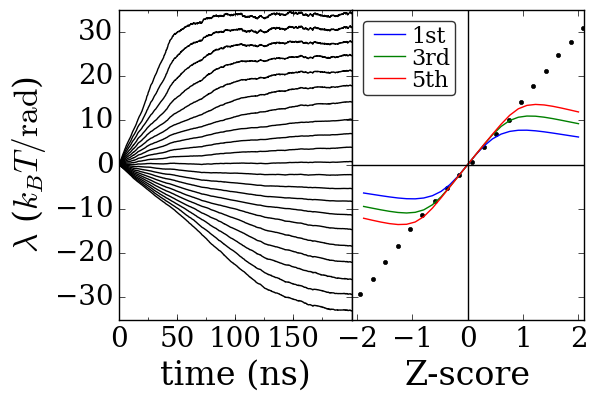

In [10]:
#NOTE, alpha_predictions file produced by mathematica notebook

target_dirs = !ls -td Trajectories/EDS-flattening-enm/flatten-dihed-mean-target/meant_*/gatp*12site* |grep -v meant_0.11

f = plt.figure(figsize=(6,4.0))
ax1 = f.add_subplot(1, 2, 1)
ax2 = f.add_subplot(1, 2, 2)

plt.subplots_adjust(wspace=0, hspace=0)
#ax1.tick_params(labelright='off')
#ax1.yaxis.set_ticks_position("left")

ax2.set_xticks(np.arange(-2,3,1.))
ax2.set_xlim(-2.1,2.1)

ax2.set_xlabel('Z-score',fontsize=24)
plt.setp([ax2.get_yticklabels() for a in f.axes[:-1]], visible=False)


alpha_predictions_phi = np.loadtxt("alpha_predictions_rev2.dat.txt")

target_list = []
emperical_results_extracted = []
for data_dir in target_dirs:
    cv_file = !ls -d {data_dir}/*.colvars.dat
    target = float(os.path.basename(os.path.dirname(os.path.dirname(cv_file[0]))).split('_')[1])
    #if target<0.25: continue
    target_list.append(target)
    cv_data = np.loadtxt(cv_file[0])
    ax1.plot(cv_data[::10,0]/1e3,cv_data[::10,3]/2.577,color='k')
    emperical_results_extracted.append( (-target,
                                         cv_data[-len(cv_data)//20:,3].mean(axis=0)))

emperical_results_extracted = np.array(sorted(emperical_results_extracted,key=lambda x: x[0]))

noeds_ref_data = get_table_results(noeds_gatp_ref,150)
print noeds_ref_data

sig_t = np.sqrt(noeds_ref_data['mean_t2']-noeds_ref_data['mean_t']**2)
ax2.plot((emperical_results_extracted[:,0]-np.radians(noeds_ref_data['mean_t']))/np.radians(sig_t),
         emperical_results_extracted[:,1]/2.577,marker='o',c='k',markersize=3,linestyle='')

ax2.plot(-alpha_predictions_phi[:,0],alpha_predictions_phi[:,1],label='1st')
ax2.plot(-alpha_predictions_phi[:,0],alpha_predictions_phi[:,2],label='3rd')
ax2.plot(-alpha_predictions_phi[:,0],alpha_predictions_phi[:,3],label='5th')
#ax2.plot((alphas_emperical_phi[:,0]-0.335652)/0.0472641,
#         alphas_emperical_phi[:,1]/2.577,marker='o',c='k',markersize=5,linestyle='')


ax2.axhline(0,ls='-',color='k')
ax2.axvline(0,ls='-',color='k')
ax1.set_ylim(-35,35)
ax2.set_ylim(-35,35)


ax1.set_xlim(0,200)
ax1.set_xticks(np.arange(0,200,50),minor=False)
ax1.set_xticks(np.arange(0,200,25),minor=True)
ax1.set_xlabel('time (ns)',fontsize=24)

ax2.legend(loc='upper left',fontsize=16,fancybox=True,framealpha=0.8,labelspacing=0,borderpad=0.2,handletextpad=0)
ax1.set_ylabel('$\lambda$ ($k_B T/{\mathrm{rad}}$)',fontsize=24)
plt.savefig(os.path.join(output_directory_cg_eds,'alpha-vs-prediction.pdf'),bbox_inches='tight',transparent=True)


In [11]:
def read_data_dir(dirname,extension='colvars.dat',tau=''):
    if tau:
        data_files = !ls -rtd {dirname}/*.{tau}ps.*.{extension}
    else:
        data_files = !ls -rtd {dirname}/*.{extension}
    data = None
    for data_file in data_files:
        if data is None:
            data = np.loadtxt(data_file)[:-1]
        else:
            data = np.append(data,np.loadtxt(data_file)[1:],axis=0)
    return data

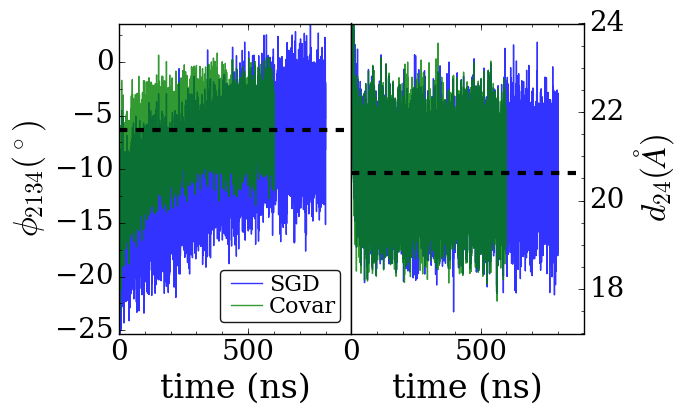

In [12]:
f = plt.figure(figsize=(6,4.0))
ax1 = f.add_subplot(1, 2, 1)
ax2 = f.add_subplot(1, 2, 2,sharex=ax1)

#plt.setp([ax2.get_yticklabels() for a in f.axes[:-1]], visible=False)
#next line is hack to set exact size
#plt.subplots_adjust(0,0,1,1,wspace=0, hspace=0)
plt.subplots_adjust(wspace=0, hspace=0)
ax1.tick_params(labelright='off')
ax1.yaxis.set_ticks_position("left")

ax2.tick_params(labelleft='off',labelright='on')
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position("right")


ax1.set_xlim(0,900)
ax1.set_xlabel('time (ns)',fontsize=24)
ax2.set_xlabel('time (ns)',fontsize=24)



ax1.set_xticks(np.arange(0,900,500),minor=False)
ax1.set_xticks(np.arange(0,900,100),minor=True)


ax1.set_yticks(np.arange(-30,5,5),minor=False)
ax1.set_yticks(np.arange(-30,5,2.5),minor=True)

ax2.set_yticks(np.arange(0,50,2),minor=False)
ax2.set_yticks(np.arange(0,50,0.5),minor=True)

ax2.set_ylim(17,24)
ax1.set_ylabel('$\phi_{2134} (^\circ)$',fontsize=24)
ax2.set_ylabel('$d_{24} (\AA)$',fontsize=24)


sgd_4cv_data = read_data_dir("Trajectories/EDS-flattening-enm/flatten-dihed-mean-mean2-cleft-mean-mean2/sgd/gatp-enm-12site_FEStart_eq175ns.range10_init0/",tau="100")

covar_4cv_data = read_data_dir("Trajectories/EDS-flattening-enm/flatten-dihed-mean-mean2-cleft-mean-mean2/simul/gatp-enm-12site_FEStart_eq175ns.range1_init0/",tau="100")
        
ax1.plot(sgd_4cv_data[::5,0]/1e3,-np.degrees(sgd_4cv_data[::5,2]),label='SGD',alpha=0.8)
ax1.plot(covar_4cv_data[::5,0]/1e3,-np.degrees(covar_4cv_data[::5,2]),label='Covar',alpha=0.8)

ax2.plot(sgd_4cv_data[::5,0]/1e3,sgd_4cv_data[::5,1]*10,label='SGD',alpha=0.8)
ax2.plot(covar_4cv_data[::5,0]/1e3,covar_4cv_data[::5,1]*10,label='Covar',alpha=0.8)

ax1.axhline(target_t,linestyle='--',color='k',lw=3)
ax2.axhline(target_d,linestyle='--',color='k',lw=3)
ax1.legend(loc='lower right',fontsize=16,fancybox=True,framealpha=0.9,labelspacing=0,borderpad=0.2,handletextpad=0)

plt.savefig(os.path.join(output_directory_cg_eds,'single-vs-simul.pdf'),bbox_inches='tight',transparent=True)


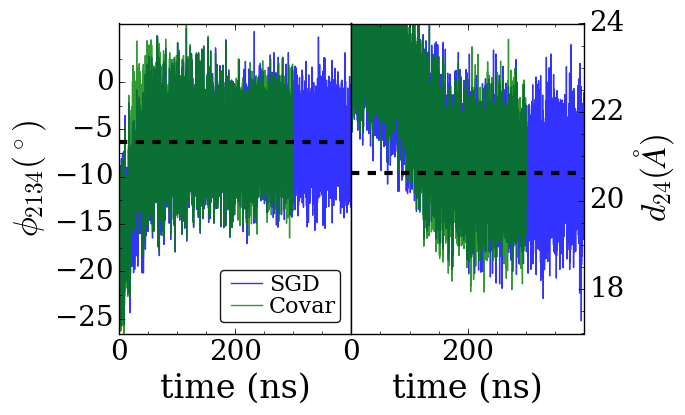

In [13]:
f = plt.figure(figsize=(6.0,4.0))
ax1 = f.add_subplot(1, 2, 1)
ax2 = f.add_subplot(1, 2, 2,sharex=ax1)

#plt.setp([ax2.get_yticklabels() for a in f.axes[:-1]], visible=False)
#next line is hack to set exact size
#plt.subplots_adjust(0,0,1,1,wspace=0, hspace=0)
plt.subplots_adjust(wspace=0, hspace=0)
ax1.tick_params(labelright='off')
ax1.yaxis.set_ticks_position("left")

ax2.tick_params(labelleft='off',labelright='on')
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position("right")


ax1.set_xlim(0,400)
#ax1.set_xlabel('time (ns)',fontsize=11)
#ax2.set_xlabel('time (ns)',fontsize=11)


ax1.set_xticks(np.arange(0,400,200),minor=False)
ax1.set_xticks(np.arange(0,400,50),minor=True)


ax1.set_yticks(np.arange(-30,5,5),minor=False)
ax1.set_yticks(np.arange(-30,5,2.5),minor=True)

ax2.set_yticks(np.arange(0,50,2),minor=False)
ax2.set_yticks(np.arange(0,50,0.5),minor=True)

ax2.set_ylim(17,24)
ax1.set_ylabel('$\phi_{2134} (^\circ)$',fontsize=24)
ax2.set_ylabel('$d_{24} (\AA)$',fontsize=24)


sgd_2cv_data = read_data_dir("Trajectories/EDS-flattening-enm/flatten-dihed-mean-cleft-mean/sgd/gatp-enm-12site_FEStart_eq175ns.range10_init0/",tau="10")

covar_2cv_data = read_data_dir("Trajectories/EDS-flattening-enm/flatten-dihed-mean-cleft-mean/simul/gatp-enm-12site_FEStart_eq175ns.range1_init0/",tau="10")
        
ax1.plot(sgd_2cv_data[::5,0]/1e3,-np.degrees(sgd_2cv_data[::5,2]),label='SGD',alpha=0.8)
ax1.plot(covar_2cv_data[::5,0]/1e3,-np.degrees(covar_2cv_data[::5,2]),label='Covar',alpha=0.8)

ax2.plot(sgd_2cv_data[::5,0]/1e3,sgd_2cv_data[::5,1]*10,label='SGD',alpha=0.8)
ax2.plot(covar_2cv_data[::5,0]/1e3,covar_2cv_data[::5,1]*10,label='Covar',alpha=0.8)

ax1.axhline(target_t,linestyle='--',color='k',lw=3)
ax2.axhline(target_d,linestyle='--',color='k',lw=3)
ax1.legend(loc='lower right',fontsize=16,fancybox=True,framealpha=0.9,labelspacing=0,borderpad=0.2,handletextpad=0)

ax1.set_xlabel('time (ns)',fontsize=24)
ax2.set_xlabel('time (ns)',fontsize=24)

plt.savefig(os.path.join(output_directory_cg_eds,'single-vs-simul-2cv.pdf'),bbox_inches='tight',transparent=True)

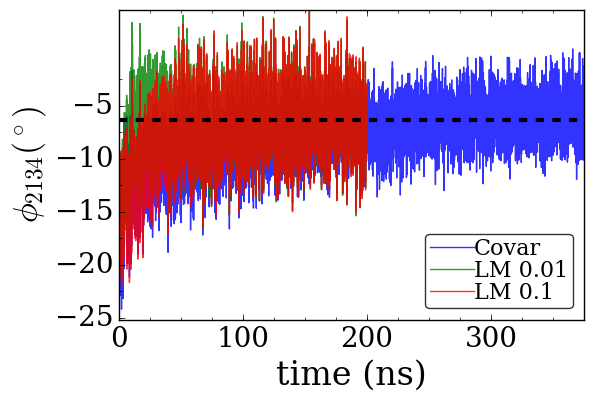

In [14]:
#f = plt.figure(figsize=(2.8,1.5))
#ax1 = f.add_subplot(1, 2, 1)
#ax2 = f.add_subplot(1, 2, 2,sharex=ax1)

f = plt.figure(figsize=(6.0,4.0))
ax1 = f.add_subplot(1, 1, 1)


#plt.setp([ax2.get_yticklabels() for a in f.axes[:-1]], visible=False)
#next line is hack to set exact size
#plt.subplots_adjust(0,0,1,1,wspace=0, hspace=0)
plt.subplots_adjust(wspace=0, hspace=0)
ax1.tick_params(labelright='off')
ax1.yaxis.set_ticks_position("left")

ax2.tick_params(labelleft='off',labelright='on')
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position("right")


ax1.set_xlim(0,350)
ax1.set_xlabel('time (ns)',fontsize=24)
ax2.set_xlabel('time (ns)',fontsize=24)

ax1.set_xticks(np.arange(0,400,100),minor=False)
ax1.set_xticks(np.arange(0,400,25),minor=True)

ax1.set_yticks(np.arange(-30,0,5),minor=False)
ax1.set_yticks(np.arange(-30,0,2.5),minor=True)

ax2.set_yticks(np.arange(0,50,1),minor=False)
ax2.set_yticks(np.arange(0,50,0.5),minor=True)
ax2.set_ylim(22,26)
ax1.set_ylabel('$\phi_{2134} (^\circ)$',fontsize=24)
ax2.set_ylabel('$d_{24} (\AA)$',fontsize=24)

simul_data_cf_lm = read_data_dir("Trajectories/EDS-flattening-enm/flatten-dihed-mean-mean2-cleft-mean-mean2/simul/gatp-enm-12site_FEStart_eq175ns.range1_init0/",tau="100")

lm_01_data = read_data_dir("Trajectories/EDS-flattening-enm/flatten-dihed-mean-mean2-cleft-mean-mean2/lm_fixed/gatp-enm-12site_FEStart_eq175ns.range1_init0_lm01",tau="100")
lm_001_data = read_data_dir("Trajectories/EDS-flattening-enm/flatten-dihed-mean-mean2-cleft-mean-mean2/lm_fixed/gatp-enm-12site_FEStart_eq175ns.range1_init0_lm001",tau="100")
lm_01_adaptive_data = read_data_dir("Trajectories/EDS-flattening-enm/flatten-dihed-mean-mean2-cleft-mean-mean2/lm_adaptive/gatp-enm-12site_FEStart_eq175ns.range1_init0_lm01",tau="100")

ax1.plot(simul_data_cf_lm[::5,0]/1e3,-np.degrees(simul_data_cf_lm[::5,2]),label='Covar',alpha=0.8)
#ax2.plot(simul_data_cf_lm[:,0]/1e3,simul_data_cf_lm[:,3]*10,label='Covar',alpha=0.8)

ax1.plot(lm_001_data[::5,0]/1e3,-np.degrees(lm_001_data[::5,2]),label='LM 0.01',alpha=0.8)
ax1.plot(lm_01_data[::5,0]/1e3,-np.degrees(lm_01_data[::5,2]),label='LM 0.1',alpha=0.8)
#ax2.plot(lm_01_data[:,0]/1e3,lm_01_data[:,3]*10,label='LM 0.1',alpha=0.8)

#ax2.plot(lm_001_data[:,0]/1e3,lm_001_data[:,3]*10,label='LM 0.01',alpha=0.8)

##add this
#ax1.plot(lm_01_adaptive_data[::50,0]/1e3,-np.degrees(lm_01_adaptive_data[::50,2]),label='LM Adapt',alpha=0.8,linestyle='',marker='o')

#ax2.plot(lm_001_adaptive_data[:,0]/1e3,lm_001_adaptive_data[:,3]*10,label='LM ADAP',alpha=0.5,color='yellow')

ax1.legend(loc='lower right',fontsize=16,fancybox=True,framealpha=0.8,labelspacing=0,borderpad=0.2,handletextpad=0,numpoints=1)
#ax2.legend(loc='lower right',fontsize=9,fancybox=True,framealpha=0.9,labelspacing=0,borderpad=0.2,handletextpad=0)
ax1.axhline(target_t,linestyle='--',color='k',lw=3)
plt.savefig(os.path.join(output_directory_cg_eds,'simul-vs-lm.pdf'),bbox_inches='tight',transparent=True)


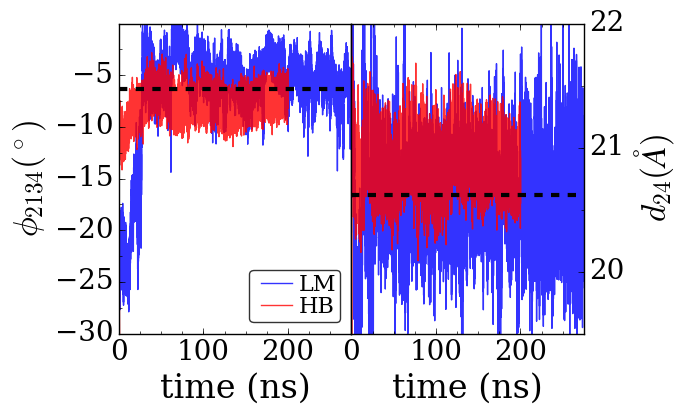

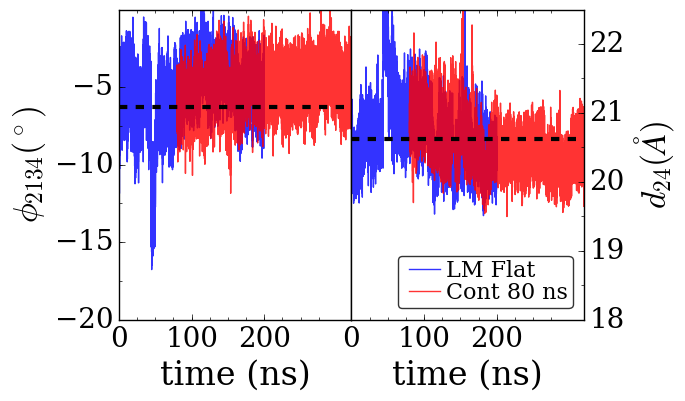

In [15]:
#figure showing all atom works, better than US
f = plt.figure(figsize=(6.0,4.0))
ax1 = f.add_subplot(1, 2, 1)
ax2 = f.add_subplot(1, 2, 2,sharex=ax1)
plt.subplots_adjust(wspace=0, hspace=0)


f2 = plt.figure(figsize=(6.0,4.0))
ax3 = f2.add_subplot(1, 2, 1)
ax4 = f2.add_subplot(1, 2, 2,sharex=ax3)

#plt.setp([ax2.get_yticklabels() for a in f.axes[:-1]], visible=False)
#next line is hack to set exact size
#plt.subplots_adjust(0,0,1,1,wspace=0, hspace=0)

plt.subplots_adjust(wspace=0, hspace=0)
#ax1.tick_params(labelright='off',labelbottom='off')
#plt.subplots_adjust(hspace=0)

#ax1.tick_params(labelright='on',labelbottom='off')
#ax3.tick_params(labelright='on',labelbottom='off')


ax1.yaxis.set_ticks_position("left")
ax1.set_ylim(-30,0)

ax3.tick_params(labelright='off')
ax3.yaxis.set_ticks_position("left")
ax3.set_ylim(-15,0)

ax2.tick_params(labelleft='off',labelright='on')
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position("right")
ax4.yaxis.set_label_position("right")
ax4.yaxis.set_ticks_position("right")

ax1.set_xlim(0,275)
ax1.set_xlabel('time (ns)',fontsize=24)
ax2.set_xlabel('time (ns)',fontsize=24)
ax3.set_xlabel('time (ns)',fontsize=24)
ax4.set_xlabel('time (ns)',fontsize=24)


ax1.set_xticks(np.arange(0,300,100),minor=False)
ax1.set_xticks(np.arange(0,300,25),minor=True)
ax3.set_xticks(np.arange(0,300,100),minor=False)
ax3.set_xticks(np.arange(0,300,25),minor=True)


ax1.set_yticks(np.arange(-30,0,5),minor=False)
ax1.set_yticks(np.arange(-30,0,2.5),minor=True)
ax3.set_ylim(-17.5,0)
ax3.set_yticks(np.arange(-20,-2.5,5),minor=False)
ax3.set_yticks(np.arange(-17.5,-2.5,2.5),minor=True)
ax3.set_ylabel('$\phi_{2134} (^\circ)$',fontsize=24)

ax2.set_yticks(np.arange(0,50,1),minor=False)
ax2.set_yticks(np.arange(0,50,0.5),minor=True)
ax2.set_ylim(19.5,22)
ax1.set_ylabel('$\phi_{2134} (^\circ)$',fontsize=24)
ax2.set_ylabel('$d_{24} (\AA)$',fontsize=24)

ax4.set_yticks(np.arange(0,50,1),minor=False)
ax4.set_yticks(np.arange(0,50,0.5),minor=True)
ax4.set_ylim(18,22.5)
ax4.set_ylabel('$d_{24} (\AA)$',fontsize=24)

us_2cv_data = read_data_dir("Trajectories/EDS-flattening-atomistic/flatten-gactin-2cv-us/run_gatpu_us_cacb_k5000")
#maybe change this dir!!
lm_4cv_data = read_data_dir("Trajectories/EDS-flattening-atomistic/flatten-gatp_4moment_lm0.1/flatten_extra_gatp_4moment_range1_i100ps_lm0.01_adaptive_p100")

ax1.plot(lm_4cv_data[:,0]/1e3,-np.degrees(lm_4cv_data[:,2]),label='LM',alpha=0.8)
ax2.plot(lm_4cv_data[:,0]/1e3,10*lm_4cv_data[:,1],label='',alpha=0.8,)

ax1.plot(us_2cv_data[:,0]/1e3,np.degrees(us_2cv_data[:,2]),label='HB',alpha=0.8,color='red')
ax2.plot(us_2cv_data[:,0]/1e3,10*us_2cv_data[:,1],label='',alpha=0.8,color='red')

ax1.axhline(-np.degrees(0.110),linestyle='--',color='k',lw=3)
ax2.axhline(20.62,linestyle='--',color='k',lw=3)
#0.110262,0.0124479,2.06155,4.25029
ax1.legend(loc='lower right',fontsize=16,fancybox=True,framealpha=0.8,labelspacing=0,borderpad=0.2,handletextpad=0)

f.savefig(os.path.join(output_directory_aa_eds,'atomistic-lm-vs-us-gatp.pdf'),bbox_inches='tight',transparent=True)

######

lm_flat_data = read_data_dir("Trajectories/EDS-flattening-atomistic/flatten-oatp_4moment/flatten_extra_oatp_4moment_range1_i100ps_lm0.1_adaptive_p100")
lm_flat_data_continue = read_data_dir("Trajectories/EDS-flattening-atomistic/flatten-oatp_4moment/flatten_extra_oatp_4moment_range1_i100ps_lm0.1_adaptive_p100/continue_fixed_40000000")

ax3.plot(lm_flat_data[:,0]/1e3,-np.degrees(lm_flat_data[:,2]),label='LM',alpha=0.8)
ax4.plot(lm_flat_data[:,0]/1e3,10*lm_flat_data[:,1],label='LM Flat',alpha=0.8)

ax3.plot(lm_flat_data_continue[:,0]/1e3,-np.degrees(lm_flat_data_continue[:,2]),label='Cont 80 ns',alpha=0.8,color='red')
ax4.plot(lm_flat_data_continue[:,0]/1e3,10*lm_flat_data_continue[:,1],label='Cont 80 ns',alpha=0.8,color='red')

ax3.axhline(-np.degrees(0.110),linestyle='--',color='k',lw=3)
ax4.axhline(20.62,linestyle='--',color='k',lw=3)
ax4.legend(loc='lower right',fontsize=16,fancybox=True,framealpha=0.8,labelspacing=0,borderpad=0.2,handletextpad=0)
#plt.savefig(os.path.join(output_directory_aa_eds,'atomistic-lm-flat.pdf'),bbox_inches='tight',transparent=True)
#plt.savefig(os.path.join(output_directory_aa_eds,'atomistic-lm-vs-us_plus-flat.pdf'),bbox_inches='tight',transparent=True)
f2.savefig(os.path.join(output_directory_aa_eds,'atomistic-lm-flat.pdf'),bbox_inches='tight',transparent=True)

gatp_us_2cv_data_aa = us_2cv_data
gatp_us_2cv_data_aa[:,2]=-gatp_us_2cv_data_aa[:,2]
gatp_lm_4cv_data_aa = lm_4cv_data

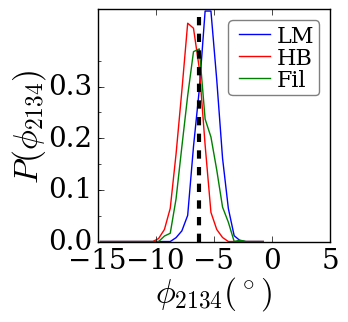

In [16]:
f = plt.figure(figsize=(3.0,3.0))
ax1 = f.add_subplot(1, 1, 1)
#ax2 = f.add_subplot(1, 2, 2)

plt.subplots_adjust(wspace=0, hspace=0)
ax1.tick_params(labelright='off')
#ax2.tick_params(labelright='on',labelleft='off')

ax1.yaxis.set_ticks_position("left")

phi_bins = np.arange(-15,0,0.5)
phi_bins_h = (phi_bins[1:]+phi_bins[:-1])/2

fil_hist,b = np.histogram(np.degrees(filament_dihedrals[-len(filament_dihedrals)//2:,0]),bins=phi_bins,density=True)
lm_hist,b = np.histogram(-np.degrees(lm_4cv_data[-len(lm_4cv_data)//30:,2]),bins=phi_bins,density=True)
us_hist,b = np.histogram(-np.degrees(us_2cv_data[-len(us_2cv_data)//20:,2]),bins=phi_bins,density=True)

ax1.plot(phi_bins_h,lm_hist,label='LM',color='blue')
ax1.plot(phi_bins_h,us_hist,label='HB',color='red')
ax1.plot(phi_bins_h,fil_hist,label='Fil',color='green')
ax1.axvline(-np.degrees(0.110),linestyle='--',color='k',lw=3)
ax1.legend(loc='upper right',fontsize=16,fancybox=True,framealpha=0.5,labelspacing=0,borderpad=0.2,handletextpad=0)
ax1.set_xlim(-15,5)
ax1.set_ylabel('$P(\phi_{2134})$',fontsize=24,labelpad=0)
ax1.set_xlabel('$\phi_{2134} (^\circ)$',fontsize=24,labelpad=0)
ax1.set_yticks(np.arange(0,0.4,0.1),minor=False)
ax1.set_yticks(np.arange(0,0.4,0.05),minor=True)
plt.savefig(os.path.join(output_directory_aa_eds,'phi_histogram.pdf'),bbox_inches='tight',transparent=True)


#d_bins = np.arange(19,23,0.2)
#d_bins_h = (d_bins[1:]+d_bins[:-1])/2
#fil_hist,b = np.histogram(10*(filament_distance[-len(filament_distance)//2:,0]),bins=d_bins,density=True)
#lm_hist,b = np.histogram(10*(lm_4cv_data[-len(lm_4cv_data)//30:,1]),bins=d_bins,density=True)
#us_hist,b = np.histogram(10*(us_2cv_data[-len(us_2cv_data)//20:,1]),bins=d_bins,density=True)

#ax2.plot(d_bins_h,lm_hist,label='LM',color='blue')
#ax2.plot(d_bins_h,us_hist,label='US',color='red')
#ax2.plot(d_bins_h,fil_hist,label='Fil',color='green')
#ax2.axvline(20.6,linestyle='--',color='k',lw=3)


In [17]:
#oda_psf_file="/project/gavoth/glen842/data/ActinFilament/setup-oda-13mer-from-monomer/run_oatp/prod_gromacs/oda-atp-13mer-frommono_ionized.notwater.psf"
#xtcfiles = !ls -tr /project/gavoth/glen842/data/ActinFilament/setup-oda-13mer-from-monomer/run_oatp/prod_gromacs/oda-atp-13mer-frommono_ionized_npt_every50ps.stepid150000000.every100ps.nowater.xtc
#oda_trj = md.load(xtcfiles,top=oda_psf_file,stride=2)
#for a in oda_trj.top.atoms: a.mass = a.element.mass
#for a in oda_trj.top.atoms: a.charge = 0
#oda_trj.forces = 0*oda_trj.xyz
oda_trj = trj

run_dir = "Trajectories/EDS-flattening-atomistic/flatten-oatp_4moment/flatten_extra_oatp_4moment_range1_i100ps_lm0.1_adaptive_p100"
psf_eds = os.path.join(run_dir,"actin-gatpu_ionized.notwater.psf")
xtcfiles = !ls -tr {run_dir}/*.nowater.xtc
trj_eds_monomer_flat = md.load(xtcfiles,top=psf_eds,stride=1)
for a in trj_eds_monomer_flat.top.atoms: a.mass = a.element.mass
for a in trj_eds_monomer_flat.top.atoms: a.charge = 0
trj_eds_monomer_flat.forces = 0*trj_eds_monomer_flat.xyz


run_dir = "Trajectories/EDS-flattening-atomistic/flatten-gatp_4moment_lm0.1/flatten_extra_gatp_4moment_range1_i100ps_lm0.01_adaptive_p100"
psf_eds = os.path.join(run_dir,"actin-gatpu_ionized.notwater.psf")
xtcfiles = !ls -tr {run_dir}/*.nowater.xtc
trj_eds_monomer = md.load(xtcfiles,top=psf_eds,stride=2)
for a in trj_eds_monomer.top.atoms: a.mass = a.element.mass
for a in trj_eds_monomer.top.atoms: a.charge = 0
trj_eds_monomer.forces = 0*trj_eds_monomer.xyz

In [18]:
#figure showing that matching angle improves RMSD

selstring="(name CA or name CB)"
from actin_cg import mdtraj_twelvesite_template as mdtraj_twelvesite_template
sel_list,label_list, resSeq_list, segment_id_list, chain_list = mdtraj_twelvesite_template(1,actin_seg_template='A and '+selstring)

actin_gatpu_eds_12site_cacb = cgmap.cg_by_selection(trj_eds_monomer,sel_list, bead_label_list=label_list, resSeq_list=resSeq_list, segment_id_list=segment_id_list )
gatpu_eds_dihedral = ( md.compute_dihedrals(actin_gatpu_eds_12site_cacb, ((1,0,2,3),),periodic=True) )

actin_oatpu_eds_12site_cacb = cgmap.cg_by_selection(trj_eds_monomer_flat,sel_list, bead_label_list=label_list, resSeq_list=resSeq_list, segment_id_list=segment_id_list )
oatpu_eds_dihedral = ( md.compute_dihedrals(actin_oatpu_eds_12site_cacb, ((1,0,2,3),),periodic=True) )


oda_subunits_backbone_trj = []
for i in range(1,14):
    oda_ca_list = oda_trj.top.select('segname A%i and backbone'%i)
    oda_subunits_backbone_trj.append( oda_trj.atom_slice(oda_ca_list) )

eds_ca_list = trj_eds_monomer.top.select('backbone and protein')
gatpu_eds_ca = trj_eds_monomer.atom_slice(eds_ca_list)
oatpu_eds_ca = trj_eds_monomer_flat.atom_slice(eds_ca_list)


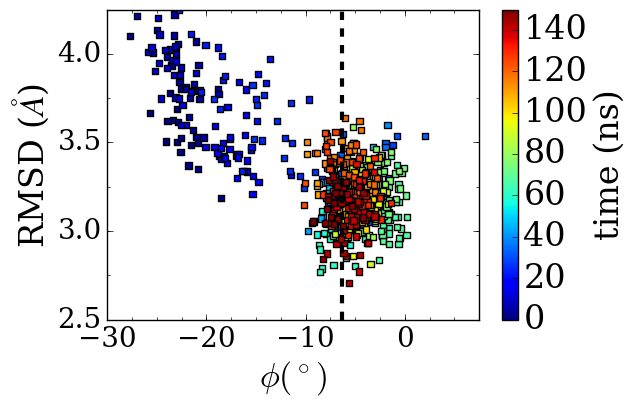

In [19]:
ref_id = 0
rmsd_t_gactin = []
rmsd_t_flat = []
n_oda_frames = len(oda_subunits_backbone_trj[ref_id])
for cf_frame in range(n_oda_frames//2,n_oda_frames,n_oda_frames//10):
    gatpu_eds_ca = gatpu_eds_ca.superpose(oda_subunits_backbone_trj[ref_id],frame=cf_frame)
    oatpu_eds_ca = oatpu_eds_ca.superpose(oda_subunits_backbone_trj[ref_id],frame=cf_frame)

    rmsd_t_flat.append(md.rmsd(oatpu_eds_ca,oda_subunits_backbone_trj[ref_id],cf_frame)*10)
    rmsd_t_gactin.append(md.rmsd(gatpu_eds_ca,oda_subunits_backbone_trj[ref_id],cf_frame)*10)
rmsd_t_flat = np.array(rmsd_t_flat)
rmsd_t_gactin = np.array(rmsd_t_gactin)



f = plt.figure(figsize=(6,4.))
ax1 = f.add_subplot(1, 1, 1)
#ax2 = f.add_subplot(2, 1, 2,sharex=ax1)
#plt.subplots_adjust(wspace=0, hspace=0)
#ax1.tick_params(labelright='off',labelbottom='off')

use_frames = gatpu_eds_ca.time/1e3<150
plot1 = ax1.scatter( np.degrees(gatpu_eds_dihedral)[use_frames,0],rmsd_t_gactin.mean(axis=0)[use_frames],c=gatpu_eds_ca.time[use_frames]/1e3,marker='s',label='G')

#use_frames = oatpu_eds_ca.time/1e3<150
#plot2 = ax2.scatter( np.degrees(oatpu_eds_dihedral)[use_frames,0],rmsd_t_flat.mean(axis=0)[use_frames],c=oatpu_eds_ca.time[use_frames]/1e3,label='F')


#print rmsd_t[0],np.degrees(gatpu_eds_dihedral[0]),np.degrees(target_meant)
ax1.axvline(-np.degrees(0.110),linestyle='--',color='k',lw=3)
#ax2.axvline(-np.degrees(0.110),linestyle='--',color='k',lw=3)


ax1.set_ylabel('RMSD ($\\AA$)',fontsize=24)
ax1.set_xlabel('$\phi (^\circ)$',fontsize=24)
#ax1.legend(loc='lower left',fontsize=9,fancybox=True,framealpha=0.8,labelspacing=0,borderpad=0.2,handletextpad=0,scatterpoints=1)
#ax2.legend(loc='lower left',fontsize=9,fancybox=True,framealpha=0.8,labelspacing=0,borderpad=0.2,handletextpad=0,scatterpoints=1)
cb = plt.colorbar(plot1)
cb.set_label(label='time (ns)',size=24)
cb.ax.tick_params(labelsize=24)
cb.set_ticks(np.arange(0,160,20))

ax1.set_ylim(2.5,4.25)
#ax2.set_ylim(2.0,3.25)

ax1.set_yticks(np.arange(2.5,4.25,0.5),minor=False)
ax1.set_yticks(np.arange(2.5,4.25,0.25),minor=True)

#ax2.set_yticks(np.arange(2.0,3.25,0.5),minor=False)
#ax2.set_yticks(np.arange(2.0,3.25,0.25),minor=True)

ax1.set_xticks(np.arange(-30,5,10),minor=False)
ax1.set_xticks(np.arange(-30,10,2.5),minor=True)

plt.savefig(os.path.join(output_directory_aa_eds,'rmsd_vs_phi_time.pdf'),bbox_inches='tight',transparent=True)


In [20]:
# further AA analysis?
run_dir = "Trajectories/EDS-flattening-atomistic/flatten-oatp_4moment/flatten_extra_oatp_4moment_range1_i100ps_lm0.1_adaptive_p100/continue_fixed_40000000"
psf_eds = os.path.join(run_dir,"actin-gatpu_ionized.notwater.psf")
xtcfiles = !ls -tr {run_dir}/*.nowater.xtc
trj_eds_monomer_flat_fixed = md.load(xtcfiles,top=psf_eds,stride=1)
for a in trj_eds_monomer_flat_fixed.top.atoms: a.mass = a.element.mass
for a in trj_eds_monomer_flat_fixed.top.atoms: a.charge = 0
trj_eds_monomer_flat_fixed.forces = 0*trj_eds_monomer_flat_fixed.xyz

print trj_eds_monomer_flat_fixed

<mdtraj.Trajectory with 284 frames, 6094 atoms, 592 residues, and unitcells>


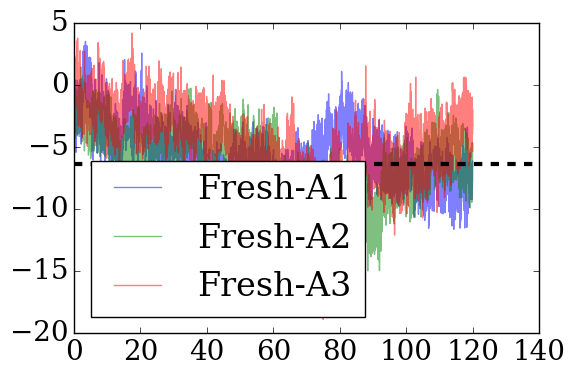

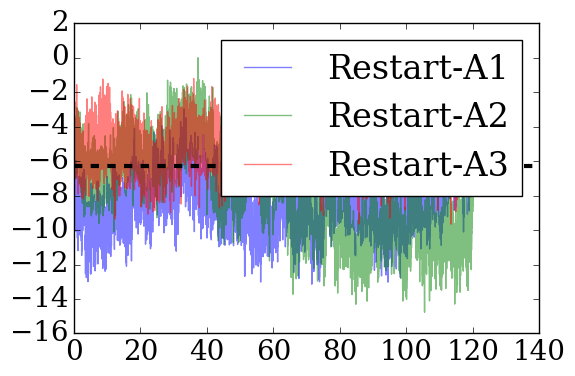

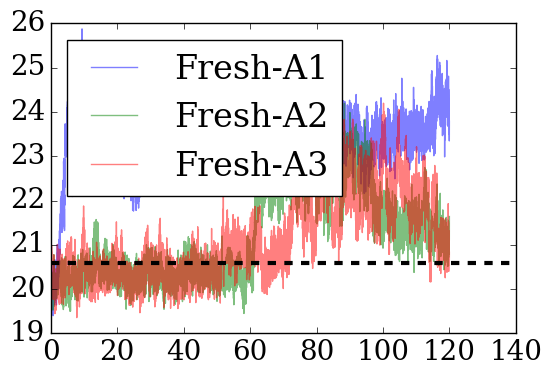

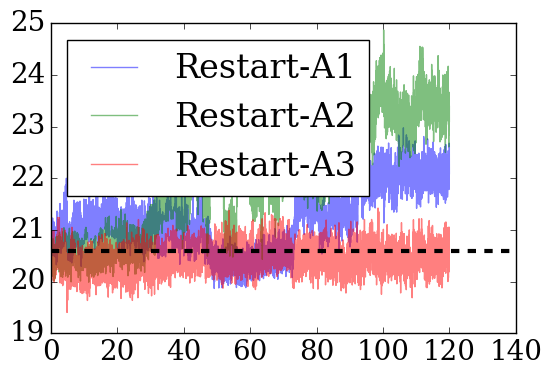

In [21]:
#trimer data
trimer_fresh_dir = "Trajectories/EDS-flattening-atomistic/flatten-trimer-angular-lm-t12/flatten_trimer_3phi_extraflat_ang_i100ps_lm0.01_p100"
trimer_restart_dir = "Trajectories/EDS-flattening-atomistic/flatten-trimer-angular-lm-t12/flatten_trimer_3phi_continue_extraflat_ang_i100ps_lm0.01_p100"

trimer_fresh_data = read_data_dir(trimer_fresh_dir)
trimer_restart_data = read_data_dir(trimer_restart_dir)

plt.figure()
plt.plot(trimer_fresh_data[:,0]/1e3,-np.degrees(trimer_fresh_data[:,2]),label='Fresh-A1',alpha=0.5)
plt.plot(trimer_fresh_data[:,0]/1e3,-np.degrees(trimer_fresh_data[:,4]),label='Fresh-A2',alpha=0.5)
plt.plot(trimer_fresh_data[:,0]/1e3,-np.degrees(trimer_fresh_data[:,6]),label='Fresh-A3',alpha=0.5)
plt.axhline(np.degrees(-0.11),color='k',lw=3,ls='--')
plt.legend(loc=0)

plt.figure()

plt.plot(trimer_restart_data[:,0]/1e3-100,-np.degrees(trimer_restart_data[:,2]),label='Restart-A1',alpha=0.5)
plt.plot(trimer_restart_data[:,0]/1e3-100,-np.degrees(trimer_restart_data[:,4]),label='Restart-A2',alpha=0.5)
plt.plot(trimer_restart_data[:,0]/1e3-100,-np.degrees(trimer_restart_data[:,6]),label='Restart-A3',alpha=0.5)
plt.axhline(np.degrees(-0.11),color='k',lw=3,ls='--')
plt.legend(loc=0)

plt.figure()
plt.plot(trimer_fresh_data[:,0]/1e3,10*(trimer_fresh_data[:,1]),label='Fresh-A1',alpha=0.5)
plt.plot(trimer_fresh_data[:,0]/1e3,10*(trimer_fresh_data[:,3]),label='Fresh-A2',alpha=0.5)
plt.plot(trimer_fresh_data[:,0]/1e3,10*(trimer_fresh_data[:,5]),label='Fresh-A3',alpha=0.5)
plt.axhline(20.6,color='k',lw=3,ls='--')
plt.legend(loc=0)

plt.figure()

plt.plot(trimer_restart_data[:,0]/1e3-100,10*(trimer_restart_data[:,1]),label='Restart-A1',alpha=0.5)
plt.plot(trimer_restart_data[:,0]/1e3-100,10*(trimer_restart_data[:,3]),label='Restart-A2',alpha=0.5)
plt.plot(trimer_restart_data[:,0]/1e3-100,10*(trimer_restart_data[:,5]),label='Restart-A3',alpha=0.5)
plt.axhline(20.6,color='k',lw=3,ls='--')
plt.legend(loc=0)


In [22]:
print 0.110262,0.0124479,2.06155,4.25029
trimer_part_data = trimer_restart_data[trimer_restart_data[:,0]/1e3>120][:,[2,4,6]].flatten()
print trimer_part_data.mean(), (trimer_part_data*trimer_part_data).mean()

0.110262 0.0124479 2.06155 4.25029
0.123035766 0.0170479485866


(0.1, 500)

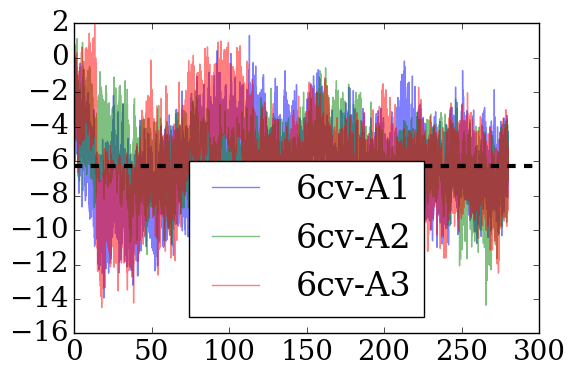

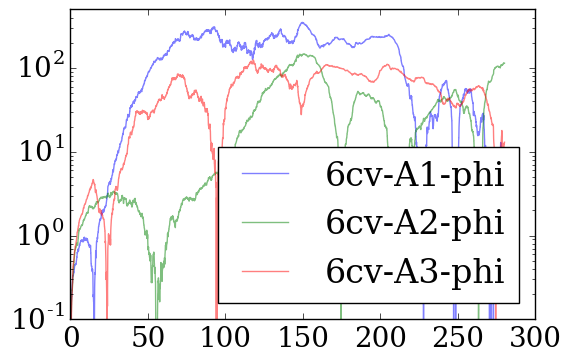

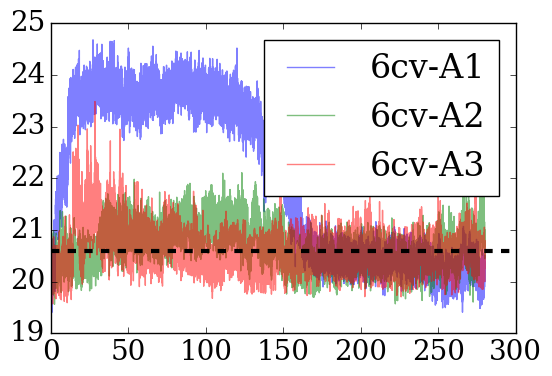

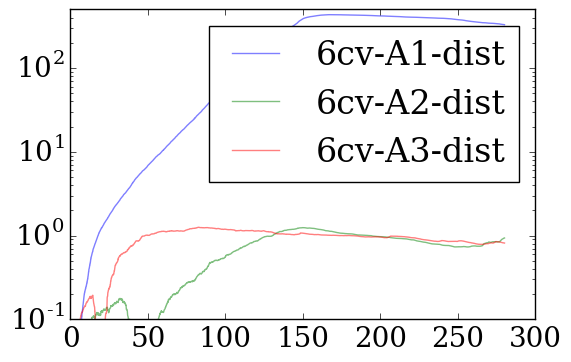

In [23]:
#trimer data
trimer_6cv_dir = "Trajectories/EDS-flattening-atomistic/flatten-trimer-angular-lm-t12/flatten_trimer_3phi_3dist_extraflat_ang_i100ps_lm0.01_p100"
trimer_6cv_cvs = read_data_dir(trimer_6cv_dir)
trimer_6cv_bias = read_data_dir(trimer_6cv_dir,extension='bias.dat')

plt.figure()
plt.plot(trimer_6cv_cvs[:,0]/1e3,-np.degrees(trimer_6cv_cvs[:,2]),label='6cv-A1',alpha=0.5)
plt.plot(trimer_6cv_cvs[:,0]/1e3,-np.degrees(trimer_6cv_cvs[:,4]),label='6cv-A2',alpha=0.5)
plt.plot(trimer_6cv_cvs[:,0]/1e3,-np.degrees(trimer_6cv_cvs[:,6]),label='6cv-A3',alpha=0.5)
plt.axhline(np.degrees(-0.11),color='k',lw=3,ls='--')
plt.legend(loc=0)

plt.figure()
plt.plot(trimer_6cv_cvs[:,0]/1e3,np.abs(trimer_6cv_bias[:,2]),label='6cv-A1-phi',alpha=0.5)
plt.plot(trimer_6cv_cvs[:,0]/1e3,np.abs(trimer_6cv_bias[:,4]),label='6cv-A2-phi',alpha=0.5)
plt.plot(trimer_6cv_cvs[:,0]/1e3,np.abs(trimer_6cv_bias[:,6]),label='6cv-A3-phi',alpha=0.5)
plt.legend(loc=0)
plt.yscale('log')
plt.ylim(0.1,500)


plt.figure()
plt.plot(trimer_6cv_cvs[:,0]/1e3,10*(trimer_6cv_cvs[:,1]),label='6cv-A1',alpha=0.5)
plt.plot(trimer_6cv_cvs[:,0]/1e3,10*(trimer_6cv_cvs[:,3]),label='6cv-A2',alpha=0.5)
plt.plot(trimer_6cv_cvs[:,0]/1e3,10*(trimer_6cv_cvs[:,5]),label='6cv-A3',alpha=0.5)
plt.axhline(20.6,color='k',lw=3,ls='--')
plt.legend(loc=0)


plt.figure()
plt.plot(trimer_6cv_cvs[:,0]/1e3,np.abs(trimer_6cv_bias[:,1]),label='6cv-A1-dist',alpha=0.5)
plt.plot(trimer_6cv_cvs[:,0]/1e3,np.abs(trimer_6cv_bias[:,3]),label='6cv-A2-dist',alpha=0.5)
plt.plot(trimer_6cv_cvs[:,0]/1e3,np.abs(trimer_6cv_bias[:,5]),label='6cv-A3-dist',alpha=0.5)
plt.legend(loc=0)
plt.yscale('log')
plt.ylim(0.1,500)




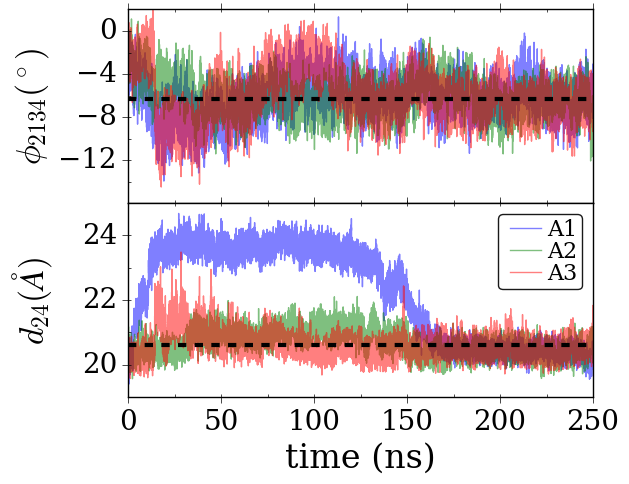

In [24]:
f = plt.figure(figsize=(6.,5.0))
ax1 = f.add_subplot(2, 1, 1)
ax2 = f.add_subplot(2, 1, 2,sharex=ax1)


plt.setp([ax1.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.subplots_adjust(wspace=0, hspace=0)

ax1.plot(trimer_6cv_cvs[:,0]/1e3,-np.degrees(trimer_6cv_cvs[:,2]),label='6cv-A1',alpha=0.5)
ax1.plot(trimer_6cv_cvs[:,0]/1e3,-np.degrees(trimer_6cv_cvs[:,4]),label='6cv-A2',alpha=0.5)
ax1.plot(trimer_6cv_cvs[:,0]/1e3,-np.degrees(trimer_6cv_cvs[:,6]),label='6cv-A3',alpha=0.5)
ax1.axhline(np.degrees(-0.11),color='k',lw=3,ls='--')



ax1.set_ylim(-16,2)
ax1.set_ylabel('$\phi_{2134} (^\circ)$',fontsize=24)
ax1.set_yticks(np.arange(-12,2,4),minor=False)
ax1.set_yticks(np.arange(-16,4,2),minor=True)
ax1.get_yaxis().set_tick_params(direction='out')
ax1.get_xaxis().set_tick_params(direction='out')

ax2.plot(trimer_6cv_cvs[:,0]/1e3,10*(trimer_6cv_cvs[:,1]),label='A1',alpha=0.5)
ax2.plot(trimer_6cv_cvs[:,0]/1e3,10*(trimer_6cv_cvs[:,3]),label='A2',alpha=0.5)
ax2.plot(trimer_6cv_cvs[:,0]/1e3,10*(trimer_6cv_cvs[:,5]),label='A3',alpha=0.5)
ax2.axhline(20.6,color='k',lw=3,ls='--')
ax2.legend(loc='upper right',fontsize=16,fancybox=True,framealpha=0.9,labelspacing=0,borderpad=0.2,handletextpad=0)


ax2.set_ylabel('$d_{24} (\AA)$',fontsize=24,labelpad=20)
ax2.set_yticks(np.arange(20,26,2))
ax2.set_yticks(np.arange(19,26,1),minor=True)

ax2.set_ylim(19,25)
ax2.get_yaxis().set_tick_params(direction='out')
ax2.get_xaxis().set_tick_params(direction='out')

plt.xlabel('time (ns)',fontsize=24)
ax1.set_xlim(0,250)
ax1.set_xticks(np.arange(0,250,25),minor=True)
ax1.tick_params(labelright='off')
ax1.yaxis.set_ticks_position("left")
ax2.yaxis.set_ticks_position("left")

plt.savefig(os.path.join(output_directory_aa_eds,'trimer_3angle_3dist.pdf'),bbox_inches='tight',transparent=True)


In [25]:
data_slice = trimer_6cv_cvs[(trimer_6cv_cvs[:,0]/1e3>200) * (trimer_6cv_cvs[:,0]/1e3<250)]
print "mean dist", data_slice.mean(axis=0)[1::2], (data_slice.mean(axis=0)[1::2]-2.06)/2.06
print "mean phi", data_slice.mean(axis=0)[2::2], (data_slice.mean(axis=0)[2::2]-.11)/.11
print "mean dist2", (data_slice*data_slice).mean(axis=0)[1::2], "fil:",4.25029
print "mean phi2", (data_slice*data_slice).mean(axis=0)[2::2], "fil:",0.0124479

mean dist [ 2.03950494  2.04077351  2.05246617] [-0.00994906 -0.00933325 -0.0036572 ]
mean phi [ 0.10509545  0.11578854  0.11793518] [-0.04458677  0.05262312  0.07213798]
mean dist2 [ 4.16001242  4.16530771  4.21338441] fil: 4.25029
mean phi2 [ 0.01178402  0.01388153  0.01444756] fil: 0.0124479


In [26]:
psf_file_trimer = "Trajectories/Reference/factin_3mono_ATP_ionized.notwater.psf"
trrfiles_trimer = "Trajectories/Reference/factin_3mono_ATP_angular2_ionized.stepid50000000.every100ps.nowater.xtc"
trj_trimer = md.load(trrfiles_trimer,top=psf_file_trimer,stride=2)
for a in trj_trimer.top.atoms: a.mass = a.element.mass
for a in trj_trimer.top.atoms: a.charge = 0
trj_trimer.forces = 0*trj_trimer.xyz

#coarse grain trajectories
selstring="(name CA or name CB)"
from actin_cg import mdtraj_twelvesite_template as mdtraj_twelvesite_template_cacb
sel_list,label_list, resSeq_list, segment_id_list, chain_list = mdtraj_twelvesite_template_cacb(3,actin_seg_template='A%i and '+selstring)
actin_3mer_12site_cacb = cgmap.cg_by_selection(trj_trimer,sel_list, bead_label_list=label_list, resSeq_list=resSeq_list, segment_id_list=segment_id_list )
print actin_3mer_12site_cacb
actin_3mer_dihedral = ( md.compute_dihedrals(actin_3mer_12site_cacb, ((1,0,2,3),(13,12,14,15),(25,24,26,27)),periodic=True) )
actin_3mer_dist = ( md.compute_distances(actin_3mer_12site_cacb, ((1,3),(13,15),(25,27)),periodic=True) )

print actin_3mer_dihedral.shape


<mdtraj.Trajectory with 501 frames, 36 atoms, 36 residues, and unitcells>
(501, 3)


fil: -6.31944 0.974542
gactin: -18.6808 2.83986
oatp: -18.1248 3.25068
#id biased mean/std | free mean/std
1 -6.02152600605 / 1.55752214023 | -7.23467 / 1.36848
2 -6.63419486425 / 1.24812618721 | -3.53122 / 1.35176
3 -6.75718796698 / 1.33002538456 | -4.37754 / 1.34558


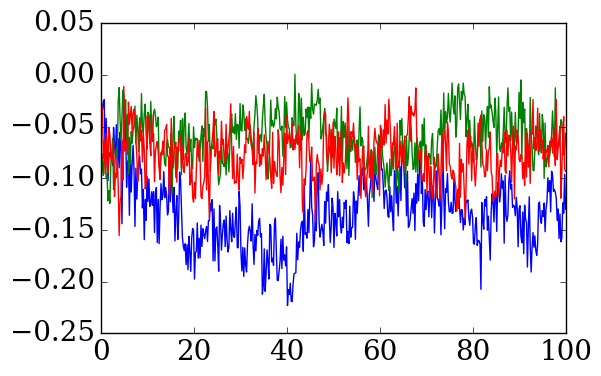

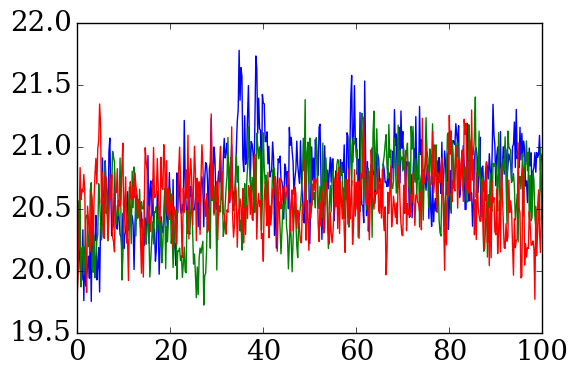

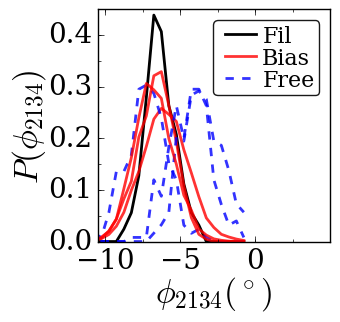

In [27]:
plt.plot(actin_3mer_12site_cacb.time/1e3,actin_3mer_dihedral[:,0])
plt.plot(actin_3mer_12site_cacb.time/1e3,actin_3mer_dihedral[:,1])
plt.plot(actin_3mer_12site_cacb.time/1e3,actin_3mer_dihedral[:,2])
plt.figure()

plt.plot(actin_3mer_12site_cacb.time/1e3,actin_3mer_dist[:,0]*10)
plt.plot(actin_3mer_12site_cacb.time/1e3,actin_3mer_dist[:,1]*10)
plt.plot(actin_3mer_12site_cacb.time/1e3,actin_3mer_dist[:,2]*10)

plt.figure()

f = plt.figure(figsize=(3,3))

#f = plt.figure(figsize=(2.8,1.5))
ax1 = f.add_subplot(1, 1, 1)
#ax2 = f.add_subplot(1, 2, 2)

#plt.setp([ax2.get_yticklabels() for a in f.axes[:-1]], visible=False)
#next line is hack to set exact size
#plt.subplots_adjust(0,0,1,1,wspace=0, hspace=0)
plt.subplots_adjust(wspace=0, hspace=0)
ax1.tick_params(labelright='off')
ax1.yaxis.set_ticks_position("left")

plt.subplots_adjust(wspace=0, hspace=0)
ax1.tick_params(labelright='off')
#ax2.tick_params(labelright='on',labelleft='off')

ax1.yaxis.set_ticks_position("left")

phi_bins = np.arange(-15,0,0.5)
phi_bins_h = (phi_bins[1:]+phi_bins[:-1])/2

fil_phis = np.degrees(filament_dihedrals[-len(filament_dihedrals)//6:,0])
fil_hist,b = np.histogram(fil_phis,bins=phi_bins,density=True)
#lm_hist,b = np.histogram(-np.degrees(lm_4cv_data[-len(lm_4cv_data)//30:,2]),bins=phi_bins,density=True)
#us_hist,b = np.histogram(np.degrees(us_2cv_data[-len(us_2cv_data)//20:,2]),bins=phi_bins,density=True)
#ax1.plot(phi_bins_h,lm_hist,label='LM',color='blue')
#ax1.plot(phi_bins_h,us_hist,label='US',color='red')
ax1.plot(phi_bins_h,fil_hist,label='Fil',color='black',lw=2)

print "fil:",fil_phis.mean(),fil_phis.std()
print "gactin:",np.degrees(gatp_dihedral).mean(), np.degrees(gatp_dihedral).std()
print "oatp:", np.degrees(fatp_dihedral[-len(fatp_dihedral)//3:]).mean(), np.degrees(fatp_dihedral[-len(fatp_dihedral)//3:]).std()
print "#id biased mean/std | free mean/std"
for i in range(3):
    #50ns
    trimer_phis = -np.degrees(data_slice[:,2+2*i]).flatten()
    trimer_hist,b = np.histogram(trimer_phis,bins=phi_bins,density=True)
    ax1.plot(phi_bins_h,trimer_hist,label='Tri/EDS',color='red',lw=2,alpha=0.8)

    unbiased_phis = np.degrees(actin_3mer_dihedral[len(actin_3mer_dihedral)//2:,i])
    unbiased_hist,b = np.histogram(unbiased_phis,bins=phi_bins,density=True)
    ax1.plot(phi_bins_h,unbiased_hist,label='Fil',color='blue',linestyle='--',lw=2,alpha=0.8)
    print i+1, trimer_phis.mean(),"/",trimer_phis.std(), "|",unbiased_phis.mean(), "/",unbiased_phis.std()
    
#ax1.axvline(-np.degrees(0.110),linestyle='--',color='k',lw=3)
#ax1.legend(loc='upper left',fontsize=16,fancybox=True,framealpha=0.5,labelspacing=0,borderpad=0.2,handletextpad=0)
ax1.set_xlim(-10.5,5)
ax1.set_xticks(np.arange(-10,2.5,5))
ax1.set_xticks(np.arange(-10,4,2.5),minor=True)

ax1.set_ylabel('$P(\phi_{2134})$',fontsize=24,labelpad=0)
ax1.set_xlabel('$\phi_{2134} (^\circ)$',fontsize=24,labelpad=0)
ax1.set_yticks(np.arange(0,0.5,0.1),minor=False)
ax1.set_yticks(np.arange(0,0.5,0.05),minor=True)

ax1.legend(labels=["Fil","Bias","Free"],loc='upper right',fontsize=16,fancybox=True,framealpha=0.9,labelspacing=0,borderpad=0.2,handletextpad=0)
plt.savefig(os.path.join(output_directory_aa_eds,'phi_histogram_trimer.pdf'),bbox_inches='tight',transparent=True)

fil: 20.6157 0.176352
gactin: 24.0237927437 0.838962569833
oatp: 26.5497040749 1.09639450908
#id biased mean/std | free mean/std
1 20.395049408 / 0.207850879328 | 20.8293 / 0.229196
2 20.407735142 / 0.23477040037 | 20.7642 / 0.237192
3 20.524661718 / 0.276952094346 | 20.5581 / 0.267963


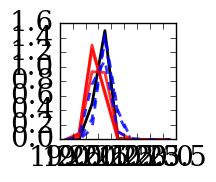

In [28]:
f = plt.figure(figsize=(1.5,1.5))
ax1 = f.add_subplot(1, 1, 1)

dist_bins = np.arange(19,24,0.5)
dist_bins_h = (dist_bins[1:]+dist_bins[:-1])/2

fil_dists = filament_distance[-len(filament_distance)//6:,0]*10
fil_hist,b = np.histogram(fil_dists,bins=dist_bins,density=True)
ax1.plot(dist_bins_h,fil_hist,label='Fil',color='black',lw=2)

print "fil:",fil_dists.mean(),fil_dists.std()
print "gactin:",gatp_distance.mean()*10, gatp_distance.std()*10
print "oatp:", fatp_distance[-len(fatp_dihedral)//3:].mean()*10, fatp_distance[-len(fatp_dihedral)//3:].std()*10

print "#id biased mean/std | free mean/std"
for i in range(3):
    #50ns
    trimer_dists = data_slice[:,1+2*i]*10
    trimer_hist,b = np.histogram(trimer_dists,bins=dist_bins,density=True)
    ax1.plot(dist_bins_h,trimer_hist,label='Tri/EDS',color='red',lw=2,alpha=0.8)

    unbiased_dists = actin_3mer_dist[len(actin_3mer_dist)//2:,i]*10
    unbiased_hist,b = np.histogram(unbiased_dists,bins=dist_bins,density=True)
    ax1.plot(dist_bins_h,unbiased_hist,label='Fil',color='blue',linestyle='--',lw=2,alpha=0.8)
    print i+1, trimer_dists.mean(),"/",trimer_dists.std(), "|",unbiased_dists.mean(), "/",unbiased_dists.std()

In [29]:
#make table
from tabulate import tabulate

ref_dict = get_table_results(filament_aa_data,250)

def make_list(name, input_dict):
    my_list = [name]
    for key in sorted(input_dict.keys()):
        val = input_dict[key]
        error = (input_dict[key]-ref_dict[key])/ref_dict[key]*100
        my_list.append("%.2f (%.1f%%)"%(val,error))
    return my_list

header=['Name']+sorted(get_table_results(noeds_gatp_ref,150).keys())
results_list = [ make_list('Oda-13mer-1sub',get_table_results(filament_aa_data,250)) ,
                make_list('G-ATP-mono',get_table_results(gatp_aa_data,175)) ,
                make_list('F-ATP-mono',get_table_results(fatp_aa_data,250)) ,
                make_list('ENM-gatp-ref',get_table_results(noeds_gatp_ref,150)) ,
                make_list('ENM-hb-k1000',get_table_results(us_1000,150)),
                make_list('ENM-hb-k10000',get_table_results(us_10000,150)),
                make_list('ENM-sgd-tau15-justphi',get_table_results(eds_mean_tau15,150)),
                                ['' for x in header],
                make_list('SGD-2CV-range10-tau10',get_table_results(sgd_2cv_data,350)),
                make_list('Covar-2CV-range1-tau10',get_table_results(covar_2cv_data,150)),
                                ['' for x in header],
                make_list('SGD-4CV-range10',get_table_results(sgd_4cv_data,750)),
                make_list('Covar-4CV-range1-tau100',get_table_results(covar_4cv_data,350)),
                make_list('LM-0.1-tau100',get_table_results(lm_01_data,150)),
                make_list('LM-0.01-tau100',get_table_results(lm_001_data,150)),
                make_list('LM-0.1 adaptive',get_table_results(lm_01_adaptive_data,150)),
                ['' for x in header],
                make_list('AA-Gatp-HB-2CV',get_table_results(gatp_us_2cv_data_aa,150)),
                make_list('AA-Gatp-LM-4CV',get_table_results(gatp_lm_4cv_data_aa,270)),
                make_list('AA-Oatp-LM-4CV',get_table_results(lm_flat_data,150)),
                make_list('AA-Oatp-freeze80-4CV',get_table_results(lm_flat_data_continue,270)),
                            ['' for x in header],
                make_list('Trimer-A1',get_table_results(trimer_6cv_cvs[:,(0,1,2)],200)),
                make_list('Trimer-A2',get_table_results(trimer_6cv_cvs[:,(0,3,4)],200)),
                make_list('Trimer-A3',get_table_results(trimer_6cv_cvs[:,(0,5,6)],200)),

               ]

results_table = tabulate(results_list,headers=header)
print results_table
table_fh = open(os.path.join(output_directory,'analysis_table_last50ns.dat'),'w')
table_fh.write(results_table)
table_fh.close()

Name                     mean_d         mean_d2         mean_t           mean_t2
-----------------------  -------------  --------------  ---------------  ---------------
Oda-13mer-1sub           20.62 (0.0%)   425.03 (0.0%)   -6.32 (-0.0%)    40.86 (0.0%)
G-ATP-mono               23.82 (15.5%)  568.15 (33.7%)  -16.93 (168.0%)  290.70 (611.4%)
F-ATP-mono               26.52 (28.6%)  704.00 (65.6%)  -17.37 (175.0%)  307.00 (651.3%)
ENM-gatp-ref             23.95 (16.2%)  574.24 (35.1%)  -17.44 (176.1%)  317.18 (676.2%)
ENM-hb-k1000             23.79 (15.4%)  566.72 (33.3%)  -10.54 (66.8%)   116.27 (184.5%)
ENM-hb-k10000            23.82 (15.5%)  568.04 (33.6%)  -6.95 (9.9%)     49.07 (20.1%)
ENM-sgd-tau15-justphi    23.88 (15.8%)  570.98 (34.3%)  -6.30 (-0.2%)    54.97 (34.5%)

SGD-2CV-range10-tau10    20.62 (-0.0%)  425.72 (0.2%)   -6.48 (2.6%)     52.02 (27.3%)
Covar-2CV-range1-tau10   20.65 (0.2%)   427.28 (0.5%)   -6.53 (3.4%)     52.65 (28.8%)

SGD-4CV-range10          20.60 (-0.1%)

0.5
0.5
REMINDER: for atomistic, slow write out time so may not be accurate:


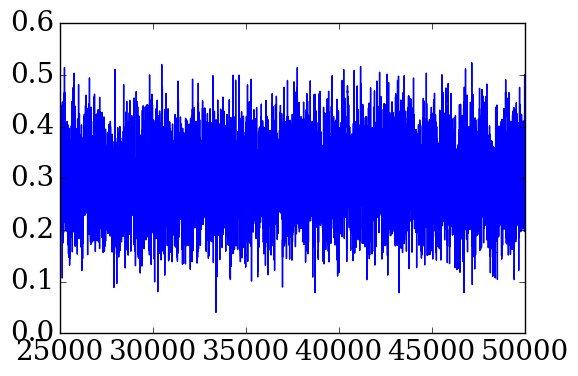

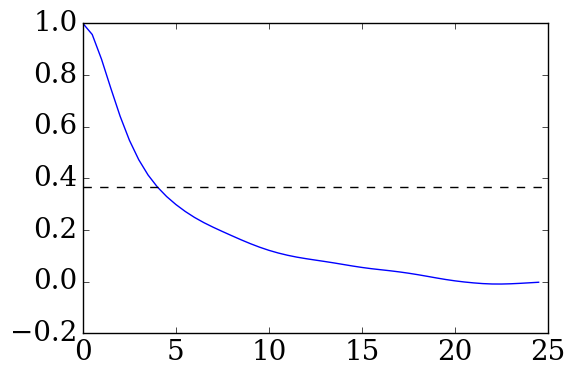

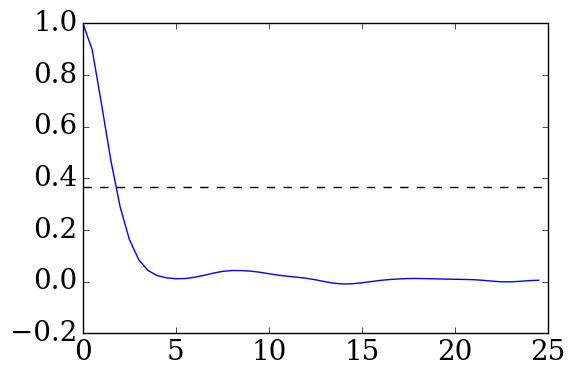

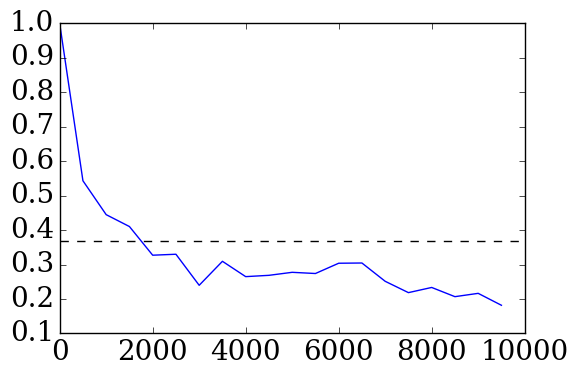

In [30]:
noeds_gatp_freq_ref = np.loadtxt("Trajectories/EDS-flattening-enm/no-eds/gatp-enm-12site_FEStart_eq175ns.no-eds/gatp-enm-12site_FEStart_eq175ns.no-eds.0.5ps.run.5000000.colvars.dat")
noeds_ref_data = noeds_gatp_freq_ref[noeds_gatp_freq_ref[:,0]/1e3>25]

plt.plot(noeds_ref_data[:,0],noeds_ref_data[:,2])

plt.figure()

#from http://stackoverflow.com/questions/14297012/estimate-autocorrelation-using-python
def acorr(op_samples, mean, separation, norm = 1):
    """autocorrelation of a measured operator with optional normalisation
    the autocorrelation is measured over the 0th axis

    Required Inputs
        op_samples  :: np.ndarray :: the operator samples
        mean        :: float :: the mean of the operator
        separation  :: int :: the separation between HMC steps
        norm        :: float :: the autocorrelation with separation=0
    """
    return ((op_samples[:op_samples.size-separation] - mean)*(op_samples[separation:]- mean)).ravel().mean() / norm

a = noeds_ref_data[:,2]
dt = noeds_ref_data[1,0]-noeds_ref_data[0,0]
print dt
m = a.mean(); rng = np.arange(50); mb = b.mean()
a1 = map(lambda t:acorr(a, m, t, a.var()), rng)
plt.plot( rng*dt,a1)
plt.axhline(1./np.e,linestyle='--',color='k')

plt.figure()

a = noeds_ref_data[:,1]
dt = noeds_ref_data[1,0]-noeds_ref_data[0,0]
print dt
m = a.mean(); rng = np.arange(50); mb = b.mean()
a1 = map(lambda t:acorr(a, m, t, a.var()), rng)
plt.plot( rng*dt,a1)
plt.axhline(1./np.e,linestyle='--',color='k')

plt.figure()

print "REMINDER: for atomistic, slow write out time so may not be accurate:"
a = gatp_dihedral
dt = actin_gatp_12site_cacb.time[1]-actin_gatp_12site_cacb.time[0]
m = a.mean(); rng = np.arange(20); mb = b.mean()
a1 = map(lambda t:acorr(a, m, t, a.var()), rng)
plt.plot( rng*dt,a1)
plt.axhline(1./np.e,linestyle='--',color='k')